Project: Traffic Sign Recognition Classifier
=========

In [168]:
from pathlib import Path
import pickle
from itertools import zip_longest
from math import ceil, sqrt
from typing import Tuple
import shutil

from IPython.display import display
from scipy.special import softmax
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

tf.compat.v1.disable_v2_behavior() 
print(f"Using TF {tf.__version__} but with TF 1 behavior.")

DATA_BASE_PATH = Path("~/data/udacity").expanduser()
MODEL_DIR = Path("./models")

Using TF 2.1.0 but with TF 1 behavior.


---
## Step 0: Load The Data

In [427]:
training_file = DATA_BASE_PATH / "train.p"
validation_file = DATA_BASE_PATH / "valid.p"
testing_file = DATA_BASE_PATH / "test.p"

with training_file.open(mode='rb') as f:
    train = pickle.load(f)
with validation_file.open(mode='rb') as f:
    valid = pickle.load(f)
with testing_file.open(mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `data/signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [437]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

# Shape of an traffic sign image:
image_shape = X_train.shape[1:]

# Number of unique classes/labels in the dataset:
n_classes = len(np.unique(y_valid))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [429]:
X_train.shape

(34799, 32, 32, 3)

In [440]:
def plot_many(idxes, save_fn=None):
    n_to_plot = len(idxes)
    ncols = 4
    nrows = ceil(n_to_plot / ncols)

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(14, nrows * 3), sharex=True, sharey=True)
    for idx, ax in zip_longest(idxes, axes.ravel()):
        if idx:
            ax.imshow(X_train[idx])
        else:
            ax.axis("off")

    plt.tight_layout()
    if save_fn:
        plt.savefig(f"examples/{save_fn}")
    plt.show()

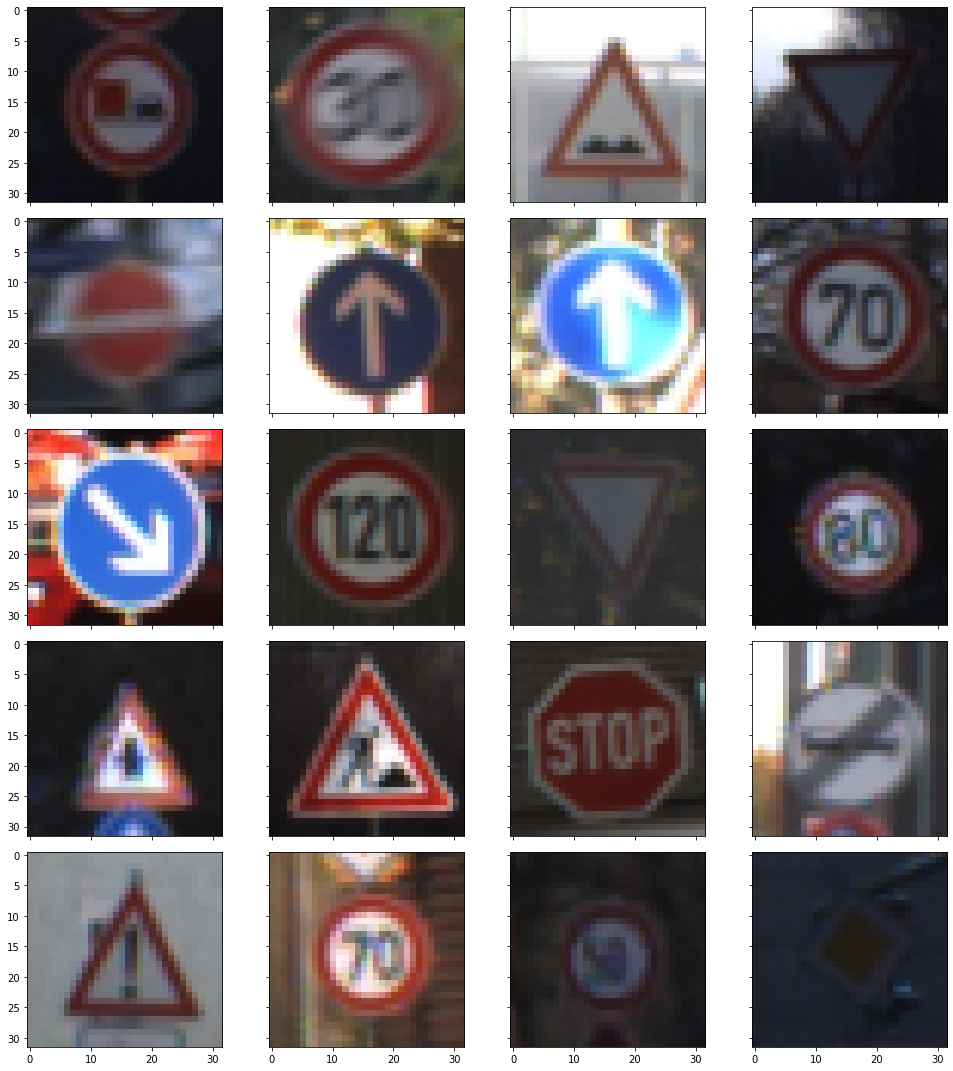

In [441]:
n_random = 20
random_idxes = np.random.choice(range(n_train), size=n_random, replace=False)

plot_many(random_idxes, "random-signs.png")

Let's take a look at the distribution of signs and inspect some that are a bit obscure (and thus potentially harder to learn): 

In [432]:
def plot_single_sign(sign):
    n_random = 12
    idxes = np.argwhere(y_train == sign).flatten()
    random_idxes = np.random.choice(idxes, size=n_random, replace=False)

    plot_many(random_idxes)
    

sign_id, sign_cnts = np.unique(y_train, return_counts=True)
sign_df = (
    pd.DataFrame({"ClassId": sign_id, "count": sign_cnts})
    .set_index("ClassId")
    .merge(
        pd.read_csv("data/signnames.csv")
        .set_index("ClassId"),
        left_index=True, 
        right_index=True
    )
    .assign(SignNameId=lambda df: df["SignName"] + " (" + df.index.astype(str) + ")")
    .sort_values(by="count", ascending=False)
)
sign_df.head()

,count,SignName,SignNameId
ClassId,,,
2,2010,Speed limit (50km/h),Speed limit (50km/h) (2)
1,1980,Speed limit (30km/h),Speed limit (30km/h) (1)
13,1920,Yield,Yield (13)
12,1890,Priority road,Priority road (12)
38,1860,Keep right,Keep right (38)


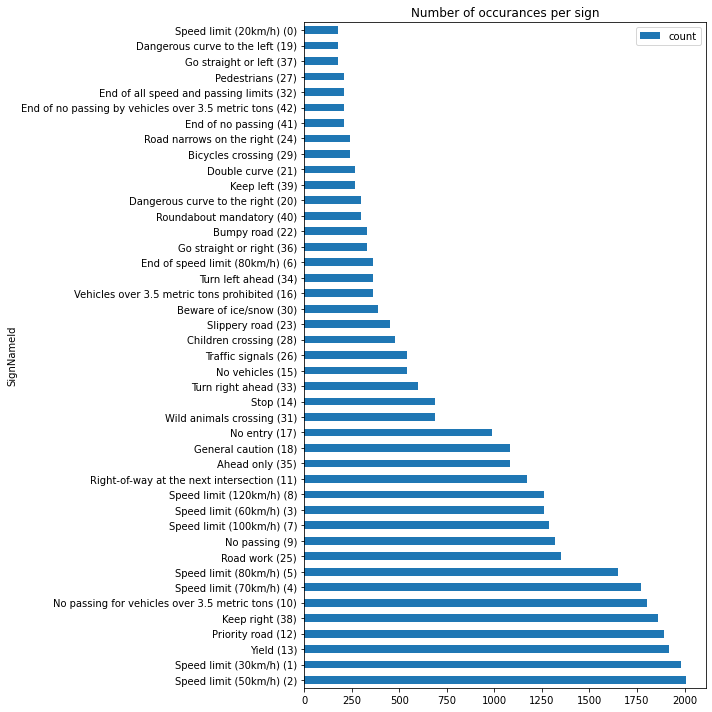

In [456]:
sign_df.plot(kind="barh", x="SignNameId", figsize=(10, 10))
plt.title("Number of occurances per sign")
plt.tight_layout()
plt.savefig("examples/sign-distribution.png", bbox_inches="tight")

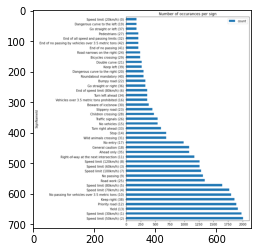

In [459]:
plt.imshow(plt.imread("examples/sign-distribution.png"))

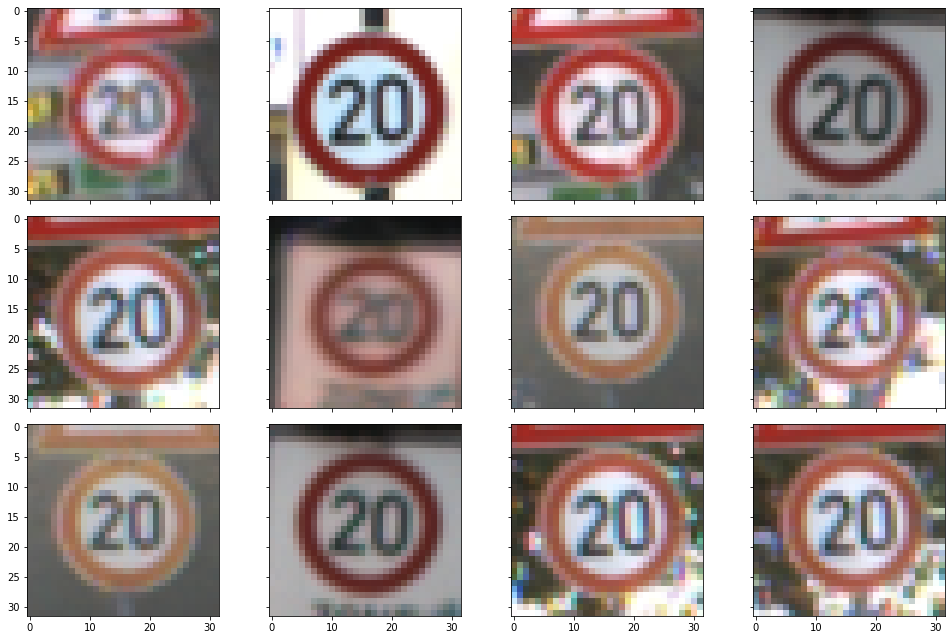

In [434]:
plot_single_sign(0)

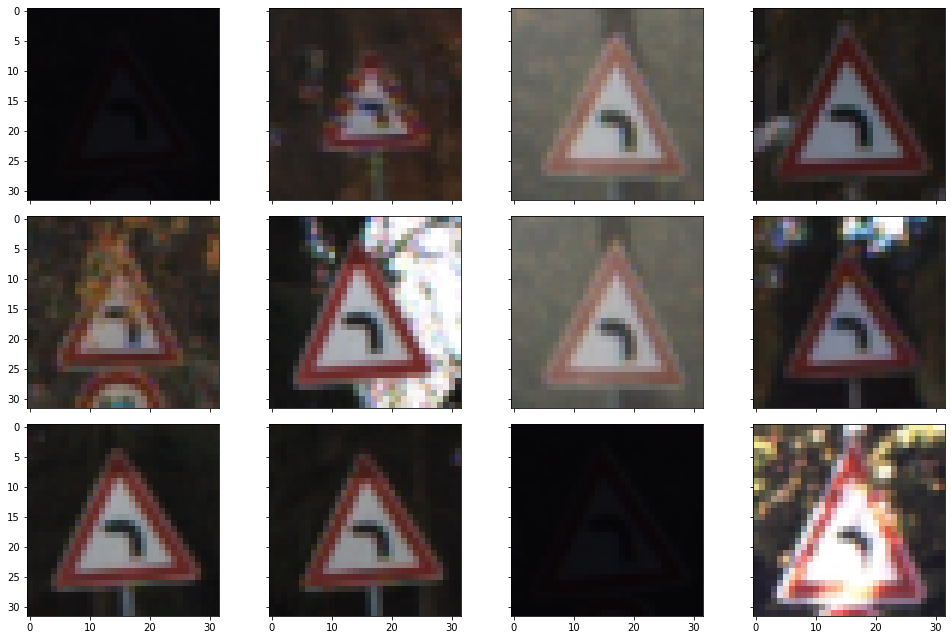

In [435]:
plot_single_sign(19)

Some are really dark, some are overexposed. Might be challenging to deal with these cases.

We could also make a better crop using the bounding box coordinates in the dataset. However, that might not be needed. I aim to introduce as little complexity as possible (until that no longer works).

----

## Step 2: Design and Test a Model Architecture

References:
- example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).
- dataset description: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
- [Reference LeNet implementation from Udacity classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/6b6c37bc-13a5-47c7-88ed-eb1fce9789a0/lessons/0fb1d383-484e-4c49-a0e4-03922c1416d6/concepts/8a6df4e1-252b-4cf5-b7b4-aac383e563c5)

Goal: $\geq .93$ accuracy on valid set.


### Step 2a: Pre-process the Data Set (normalization, grayscale, etc.)

In [463]:
X_train_raw = X_train
X_valid_raw = X_valid
X_test_raw = X_test

In [464]:
def preprocess(train_mean: float, X: np.ndarray) -> np.ndarray:
    """Preprocess data. For now, this simply normalizes the data."""
    return (X - train_mean) / 128

train_mean = X_train.mean()
X_train = preprocess(train_mean, X_train_raw)
X_valid = preprocess(train_mean, X_valid_raw)
X_test = preprocess(train_mean, X_test_raw)

### Step 2b: Model Architecture
This model is based on the LeNet implementation as covered in class, with a few changes:
- All RGB channels instead of grayscale.
- Added dropout to the two fully connected layers at the end.
- Changed the 10 hardcoded output classes to `n_classes`

In [467]:
def LeNet(x, dropout_prob):    
    # Conv layers with ReLU activation with fixed sigma. In theory, this is suboptimal.
    # He initialzation would be better. Tried this quickly but it didn't change much, so I
    # reverted back to fixed sigma for less complexity.
    sigma = .1  
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 3, 6), mean=0, 
                                                     stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 6, 16), mean=0, 
                                                     stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = Flatten()(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.random.truncated_normal(shape=(400, 120), mean=0, 
                                                   stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout.
    fc1    = tf.nn.dropout(fc1, rate=dropout_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean=0, 
                                                    stddev=sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout.
    fc2    = tf.nn.dropout(fc2, rate=dropout_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.random.truncated_normal(shape=(84, n_classes), mean=0, stddev=sigma))
                         
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Step 2c: Train, Validate and Test the Model
Again, most of the code here is based on the LeNet code covered in the lab in class.

Main changes:
- Dropout placeholder (enabled for training, disabled at test time).
- Evaluate function also outputs loss.
- Running evaluate on both train and valid.
- Collecting metrics per epoch for plots at the end (could have also used TensorBoard here, but it trains quickly enough and this is quite convenient).
- Saving checkpoint everytime we get a result with $\geq .93$ valid accuracy if it's better than the previous saved checkpoint.

In [468]:
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.compat.v1.placeholder(tf.int32, (None))
dropout_prob = tf.compat.v1.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

learning_rate = 0.0003
dropout_prob_value = .5

logits = LeNet(x, dropout_prob=dropout_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(one_hot_y), logits=logits)
loss_operation = tf.reduce_mean(input_tensor=cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

EPOCHS = 40
BATCH_SIZE = 128

In [469]:
correct_prediction = tf.equal(tf.argmax(input=logits, axis=1), tf.argmax(input=one_hot_y, axis=1))
accuracy_operation = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
saver = tf.compat.v1.train.Saver()

def evaluate(X_data, y_data) -> Tuple[float, float]:
    """Evalute model on entire input dataset, returns loss and accuracy."""
    num_examples = len(X_data)
    total_loss = 0
    total_accuracy = 0
    sess = tf.compat.v1.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], 
                             feed_dict={x: batch_x, y: batch_y, 
                                        # Ensuring that dropout is disabled at test time:
                                        dropout_prob: 0})
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

In [470]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
highest_valid_acc_so_far = 0

if MODEL_DIR.exists():
    shutil.rmtree(MODEL_DIR)

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(X_train)
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                    dropout_prob: dropout_prob_value})
            
        train_loss, train_accuracy = evaluate(X_train, y_train)
        valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"EPOCH {(i+1)} | train loss: {train_loss:5.3f} | valid loss: {valid_loss:5.3f} | "
              f"train acc: {train_accuracy:5.3f} | valid acc: {valid_accuracy:5.3f}")
    
        if valid_accuracy >= .93 and valid_accuracy > highest_valid_acc_so_far: 
            highest_valid_acc_so_far = valid_accuracy
            ckpt_name = f"epoch-{i + 1:02d}-validacc-{valid_accuracy:5.3f}"
            print(f"Valid acc target reached and better than previous (if any), saving as {ckpt_name}!")
            saver.save(sess, str(MODEL_DIR / ckpt_name))

EPOCH 1 | train loss: 1.170 | valid loss: 1.360 | train acc: 0.655 | valid acc: 0.584
EPOCH 2 | train loss: 0.546 | valid loss: 0.694 | train acc: 0.855 | valid acc: 0.801
EPOCH 3 | train loss: 0.330 | valid loss: 0.458 | train acc: 0.917 | valid acc: 0.871
EPOCH 4 | train loss: 0.242 | valid loss: 0.377 | train acc: 0.951 | valid acc: 0.902
EPOCH 5 | train loss: 0.163 | valid loss: 0.310 | train acc: 0.958 | valid acc: 0.918
EPOCH 6 | train loss: 0.143 | valid loss: 0.260 | train acc: 0.968 | valid acc: 0.934
Valid acc target reached and better than previous (if any), saving as epoch-06-validacc-0.934!
EPOCH 7 | train loss: 0.107 | valid loss: 0.242 | train acc: 0.974 | valid acc: 0.931
EPOCH 8 | train loss: 0.079 | valid loss: 0.205 | train acc: 0.980 | valid acc: 0.944
Valid acc target reached and better than previous (if any), saving as epoch-08-validacc-0.944!
EPOCH 9 | train loss: 0.074 | valid loss: 0.210 | train acc: 0.984 | valid acc: 0.944
Valid acc target reached and better 

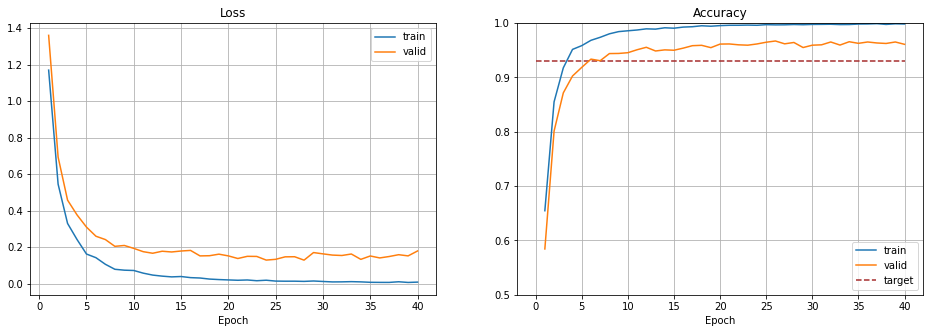

In [472]:
epoch_rng = list(range(1, EPOCHS+1))

_, (l, r) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
l.plot(epoch_rng, train_losses, label="train")
l.plot(epoch_rng, valid_losses, label="valid")
l.legend()
l.grid()
l.set_xlabel("Epoch")
l.set_title("Loss")

r.plot(epoch_rng, train_accs, label="train")
r.plot(epoch_rng, valid_accs, label="valid")
r.hlines(.93, xmin=0, xmax=EPOCHS, linestyle="--", label="target", color="brown")
r.legend()
r.grid()
r.set_xlabel("Epoch")
r.set_title("Accuracy")
r.set_ylim(0.5, 1)

plt.savefig("examples/train-log.png")
plt.show()

There is still quite a bit of overfitting here, which could be improved by introducing augmentations: subtle rotations, brightness, contrast, subtle warp transforms, crop+zooms (n.b.: no flips as that will change the meaning of some signs, e.g. sharp left / right turn). This is much easier with a high level framework, so I will leave that for future work (with e.g. Keras).

In [473]:
best_ckpt = "epoch-26-validacc-0.967"

In [474]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, str(MODEL_DIR / best_ckpt))
    
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print(f"test loss: {test_loss:5.3f} | test acc: {test_accuracy:5.3f}")

INFO:tensorflow:Restoring parameters from models/epoch-26-validacc-0.967
test loss: 0.267 | test acc: 0.942


---

## Step 3: Test a Model on New Images

To give myself more insight into how the model is working, I'm downloading five pictures of German traffic signs from the web and use the model to predict the traffic sign type.

### Load and Output the Images

In [335]:
shutil.rmtree(WEB_IMG_PATH)

In [336]:
WEB_IMG_PATH = Path("./data/web-images").resolve()
WEB_IMG_PATH.mkdir(exist_ok=True)

In [424]:
!wget -q -nc https://angelikasgerman.co.uk/wp-content/uploads/2018/02/30.jpg -O $WEB_IMG_PATH/30kmzone.jpg
!wget -q -nc https://angelikasgerman.co.uk/wp-content/uploads/2018/02/30-nicht.jpg -O $WEB_IMG_PATH/30kmzone-end.jpg
!wget -q -nc https://angelikasgerman.co.uk/wp-content/uploads/2018/02/Priority.jpg -O $WEB_IMG_PATH/priority.jpg
!wget -q -nc https://angelikasgerman.co.uk/wp-content/uploads/2018/02/Vorfahrt-achten-1024x1024.jpg -O $WEB_IMG_PATH/yield.jpg
!wget -q -nc https://angelikasgerman.co.uk/wp-content/uploads/2018/02/spielstra%C3%9Fe-1024x718.jpg -O $WEB_IMG_PATH/play_area.jpg
!wget -q -nc https://lifeistheadventure.files.wordpress.com/2011/05/no-speed-limit-sign.jpg -O $WEB_IMG_PATH/no_limit.jpg

In [388]:
web_img_paths = sorted(WEB_IMG_PATH.glob("*"))
[i.name for i in web_img_paths]

['30kmzone-end.jpg',
 '30kmzone.jpg',
 'no_limit.jpg',
 'play_area.jpg',
 'priority.jpg',
 'yield.jpg']

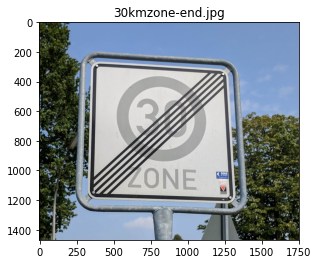

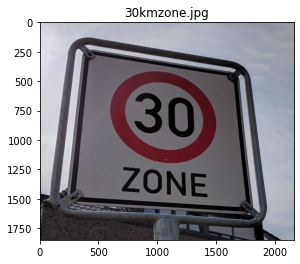

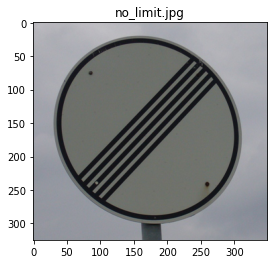

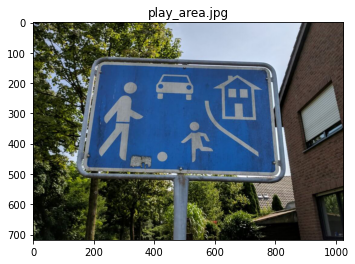

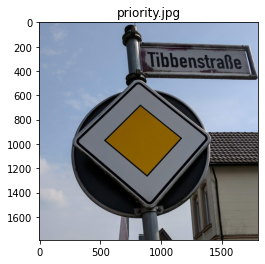

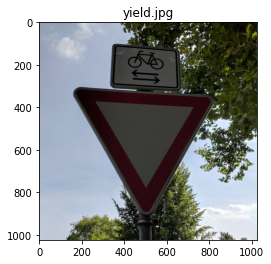

In [395]:
imgs = []

for path in web_img_paths: 
    img = plt.imread(str(path))
    
    # This one needs to be zoomed in a bit:
    if path.name == "no_limit.jpg":
        img = img[150:475, 200:550, :]
    
    imgs.append(img)
    plt.imshow(img)
    plt.title(path.name)
    plt.show()

### Predict the Sign Type for Each Image

In [396]:
X_web_raw = np.stack([cv2.resize(i, image_shape[:2], interpolation=cv2.INTER_AREA) 
                      for i in imgs])
print(X_web_raw.shape)
X_web = preprocess(train_mean, X_web_raw)

(6, 32, 32, 3)


In [397]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, str(MODEL_DIR / best_ckpt))
    
    yhat_web = sess.run(logits, feed_dict={x: X_web, dropout_prob: 0})
    print(yhat_web.shape)

INFO:tensorflow:Restoring parameters from models/epoch-37-validacc-0.954
(6, 43)


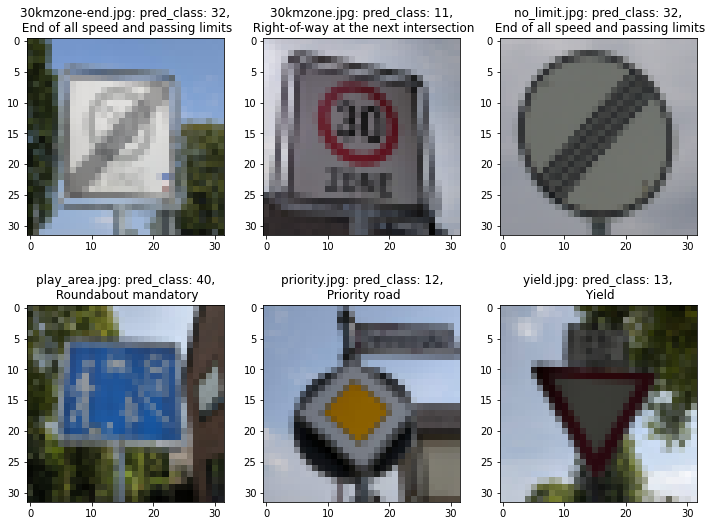

In [444]:
_, axes = plt.subplots(figsize=(12, 9), nrows=2, ncols=3)

for path, pred_logit, img, ax in zip(web_img_paths, yhat_web, X_web, axes.ravel()):
    pred_class = np.argmax(pred_logit)
    ax.set_title(f"{path.name}: pred_class: {pred_class},\n {sign_df.loc[pred_class].SignName}")
    ax.imshow((img * 128 + train_mean).astype(np.uint8))

plt.savefig("examples/web-preds.png")

### Analyze Performance

It got 3 out of 6. At first glance, it seems like it's not doing so well. But the first one (end of 30 km zone) is pretty close.
Let's see if these signs even exist in the dataset:

In [368]:
sign_df[sign_df.SignName.str.contains("30")]

,count,SignName,SignNameId
ClassId,,,
1,1980,Speed limit (30km/h),Speed limit (30km/h) (1)


No, it only contains the regular 30 km sign, but not the 30km zone signs. The play area sign also doesn't exist. So overall, it's doing pretty well actually!

So overall accuracy here is 3/6 = 50%.
But when considering only the 3 labels that actually exist in the training dataset, it's 3/3 = 100%.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [453]:
for path, pred_logit in zip(web_img_paths, yhat_web):
    probs = softmax(pred_logit)
    top_5 = np.argsort(probs)[-5:]
    
    sign_df_top5 = sign_df.loc[top_5].assign(prob=np.sort(probs)[-5:]) \
        .sort_values(by="prob", ascending=False).drop(["SignNameId", "count"], axis=1)
    
    print(f"{path.name}:")
    display(sign_df_top5)
    print(sign_df_top5.to_markdown())
    print("\n" + "-" * 80 + "\n")

30kmzone-end.jpg:


,SignName,prob
ClassId,,
32,End of all speed and passing limits,0.681861
15,No vehicles,0.289459
41,End of no passing,0.020016
38,Keep right,0.004689
12,Priority road,0.000784


|   ClassId | SignName                            |        prob |
|----------:|:------------------------------------|------------:|
|        32 | End of all speed and passing limits | 0.681861    |
|        15 | No vehicles                         | 0.289459    |
|        41 | End of no passing                   | 0.0200161   |
|        38 | Keep right                          | 0.00468865  |
|        12 | Priority road                       | 0.000784041 |

--------------------------------------------------------------------------------

30kmzone.jpg:


,SignName,prob
ClassId,,
11,Right-of-way at the next intersection,0.348971
12,Priority road,0.167663
13,Yield,0.104354
41,End of no passing,0.099633
42,End of no passing by vehicles over 3.5 metric ...,0.055615


|   ClassId | SignName                                           |      prob |
|----------:|:---------------------------------------------------|----------:|
|        11 | Right-of-way at the next intersection              | 0.348971  |
|        12 | Priority road                                      | 0.167663  |
|        13 | Yield                                              | 0.104354  |
|        41 | End of no passing                                  | 0.0996327 |
|        42 | End of no passing by vehicles over 3.5 metric tons | 0.0556152 |

--------------------------------------------------------------------------------

no_limit.jpg:


,SignName,prob
ClassId,,
32,End of all speed and passing limits,0.999547
41,End of no passing,0.000398
3,Speed limit (60km/h),0.000030
6,End of speed limit (80km/h),0.000012
1,Speed limit (30km/h),0.000005


|   ClassId | SignName                            |        prob |
|----------:|:------------------------------------|------------:|
|        32 | End of all speed and passing limits | 0.999547    |
|        41 | End of no passing                   | 0.000398194 |
|         3 | Speed limit (60km/h)                | 2.97617e-05 |
|         6 | End of speed limit (80km/h)         | 1.20205e-05 |
|         1 | Speed limit (30km/h)                | 5.16992e-06 |

--------------------------------------------------------------------------------

play_area.jpg:


,SignName,prob
ClassId,,
40,Roundabout mandatory,0.979262
38,Keep right,0.016378
39,Keep left,0.004273
15,No vehicles,0.000029
37,Go straight or left,0.000019


|   ClassId | SignName             |        prob |
|----------:|:---------------------|------------:|
|        40 | Roundabout mandatory | 0.979262    |
|        38 | Keep right           | 0.016378    |
|        39 | Keep left            | 0.00427291  |
|        15 | No vehicles          | 2.94031e-05 |
|        37 | Go straight or left  | 1.86616e-05 |

--------------------------------------------------------------------------------

priority.jpg:


,SignName,prob
ClassId,,
12,Priority road,1.000000e+00
25,Road work,4.276423e-16
42,End of no passing by vehicles over 3.5 metric ...,1.845001e-16
26,Traffic signals,6.710811e-17
10,No passing for vehicles over 3.5 metric tons,2.387798e-17


|   ClassId | SignName                                           |        prob |
|----------:|:---------------------------------------------------|------------:|
|        12 | Priority road                                      | 1           |
|        25 | Road work                                          | 4.27642e-16 |
|        42 | End of no passing by vehicles over 3.5 metric tons | 1.845e-16   |
|        26 | Traffic signals                                    | 6.71081e-17 |
|        10 | No passing for vehicles over 3.5 metric tons       | 2.3878e-17  |

--------------------------------------------------------------------------------

yield.jpg:


,SignName,prob
ClassId,,
13,Yield,1.000000e+00
12,Priority road,2.768690e-17
15,No vehicles,1.990053e-20
35,Ahead only,1.219003e-20
25,Road work,5.584497e-21


|   ClassId | SignName      |        prob |
|----------:|:--------------|------------:|
|        13 | Yield         | 1           |
|        12 | Priority road | 2.76869e-17 |
|        15 | No vehicles   | 1.99005e-20 |
|        35 | Ahead only    | 1.219e-20   |
|        25 | Road work     | 5.5845e-21  |

--------------------------------------------------------------------------------



We can observe here that the model is - overall - more certain for the signs it got right than for the signs that it got wrong (and were missing from the dataset in the first place). Although the .97 for `play_area.jpg` which gets predicted as "Roundabout mandatory" is quite worrying. This tells us that these models are not very good at dealing with unknown or new signs.

### Project Writeup

Please see `README.md` in this directory for the writeup.

*Optional step 4 omitted (it's interesting, but I have done this sort of thing before and my time is limited at the moment)*